In [1]:
import pandas as pd
import os
import copy
import matplotlib.pyplot as plt
from datetime import datetime
import math
import numpy as np

In [2]:
basepath = os.getcwd() + '/assignment2'
tagsFilepath = basepath + '/input/TrainTags.csv'
tagsFeaturesFilePath = basepath + '/SOPrediction/generated_data/tags_features.csv'
usersFilePath = basepath + '/SOPrediction/generated_data/users.csv'
ansFilepath = basepath + '/input/TrainAnswers.csv'
qnsFilepath = basepath + '/input/TrainQuestions.csv'
tagsData = pd.read_csv(tagsFilepath, encoding='latin1')
tagsFeaturesData = pd.read_csv(tagsFeaturesFilePath, encoding='latin1')
qnsData = pd.read_csv(qnsFilepath, encoding='latin1')
ansData = pd.read_csv(ansFilepath, encoding='latin1')
usersData = pd.read_csv(usersFilePath, encoding='latin1')

In [4]:
qnsData = qnsData[:50000]

In [5]:
# Note response time (in hours) of the first answer given
# If no answer posted, return -1
def get1stResponseTime(qnid):
    # Get answers for qn
    answers = ansData[ansData['ParentId'] == qnid]

    # If no answers return -1
    if len(answers) == 0:
        return -1

    # Get the datetime of the 1st answered qn
    ansDate = min(answers['CreationDate'])
    # Get when the qn was asked
    qnDate = qnsData[qnsData['Id'] == qnid]['CreationDate'].values[0]
    ansDate_dt = datetime.strptime(ansDate , "%Y-%m-%dT%H:%M:%SZ")
    qnDate_dt = datetime.strptime(qnDate , "%Y-%m-%dT%H:%M:%SZ")
    delta = ansDate_dt - qnDate_dt
    return delta.seconds/3600

In [6]:
# runs 10 mins for 1mil rows
start_time = datetime.now()
qnsData['FirstResponse'] = qnsData['Id'].apply(get1stResponseTime)
tdelta = (datetime.now() - start_time).seconds/60
print("--- %s minutes ---" % tdelta)

--- 3.6166666666666667 minutes ---


In [8]:
# len(qnsData[qnsData['FirstResponse'] == -1])
# replace -1 with max value
maxResponseTime = qnsData['FirstResponse'].max()
qnsData['FirstResponse'] = qnsData['FirstResponse'].replace(-1, 2*maxResponseTime)

In [9]:
responseTime_by_user = qnsData.groupby('OwnerUserId')['FirstResponse'].mean()
users_response_df =  pd.DataFrame({'userid':responseTime_by_user.index, 
                                   'mean_response_time':responseTime_by_user.values})

In [ ]:
def getUserAcceptRate(userid):
    acceptrate = usersData[usersData['User Id']==userid]['Accept Rate']
    if len(acceptrate) == 0:
        return -1
    return acceptrate.values[0]

start_time = datetime.now()
users_response_df['Accept Rate'] = users_response_df['userid'].apply(getUserAcceptRate)
tdelta = (datetime.now() - start_time).seconds/60
print("--- %s minutes ---" % tdelta)

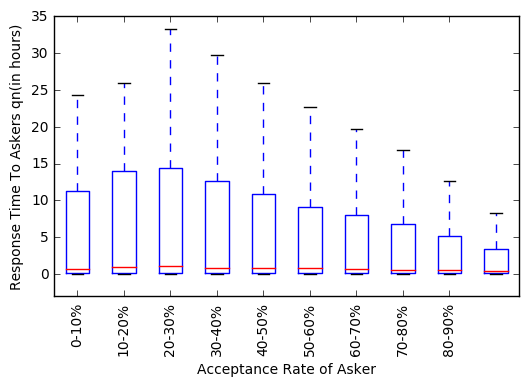

In [35]:
# ACCEPTANCE RATE VS RESPONSE TIME
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #
df = users_response_df[users_response_df['mean_response_time'] != -1].dropna()
df1 = df[df['Accept Rate'] <= 10]['mean_response_time'].values
df2 = df[df['Accept Rate'].between(11, 20, inclusive=True)]['mean_response_time'].values
df3 = df[df['Accept Rate'].between(21, 30, inclusive=True)]['mean_response_time'].values
df4 = df[df['Accept Rate'].between(31, 40, inclusive=True)]['mean_response_time'].values
df5 = df[df['Accept Rate'].between(41, 50, inclusive=True)]['mean_response_time'].values
df6 = df[df['Accept Rate'].between(51, 60, inclusive=True)]['mean_response_time'].values
df7 = df[df['Accept Rate'].between(61, 70, inclusive=True)]['mean_response_time'].values
df8 = df[df['Accept Rate'].between(71, 80, inclusive=True)]['mean_response_time'].values
df9 = df[df['Accept Rate'].between(81, 90, inclusive=True)]['mean_response_time'].values
df10 = df[df['Accept Rate'].between(91, 100, inclusive=True)]['mean_response_time'].values

fig = plt.figure()
plt.boxplot([df1,df2,df3,df4,df5,df6,df7,df8,df9,df10],0,'')
labels = ['0-10%', '10-20%', '20-30%', '30-40%', '40-50%', '50-60%', '60-70%', '70-80%', '80-90%', '90-100%']
plt.xticks(list(range(1,10)), labels,rotation='vertical')
plt.xlabel('Acceptance Rate of Asker')
plt.ylabel('Response Time To Askers qn(in hours)')
plt.ylim([-3,35])
plt.subplots_adjust(bottom=0.2)
plt.show()
fig.savefig('assignment2/ACCEPTANCE RATE VS RESPONSE TIME.png')

In [13]:
weekdays = ['Mon','Tue','Wed','Thu','Fri','Sat','Sun']
def getTimeOfDay(ansid):
    creationDate = ansData[ansData['Id']==ansid]['CreationDate'].values[0]
    creationDate_dt = datetime.strptime(creationDate, "%Y-%m-%dT%H:%M:%SZ")
    hourOfDay = creationDate_dt.hour
    periodOfDay = int(hourOfDay/4)
    # Monday is 0 and Sunday is 6
    dayOfWeek = creationDate_dt.weekday()
    return hourOfDay,periodOfDay,dayOfWeek

start_time = datetime.now()
ansData['HourOfDay'],ansData['PeriodOfDay'],ansData['DayOfWeek'] = \
    zip(*ansData['Id'].map(getTimeOfDay))
tdelta = (datetime.now() - start_time).seconds/60
print("--- %s minutes ---" % tdelta)

--- 9.45 minutes ---


CPU times: user 1e+03 ns, sys: 0 ns, total: 1e+03 ns
Wall time: 7.15 µs


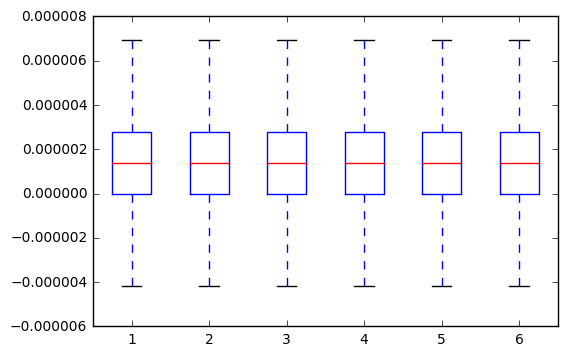

In [14]:
# ANSWER POSTED TIME - VS - ANSWER SCORE
%time
sumScore = ansData['Score'].sum()
boxplotData = []
for i in range(6):
    df = ansData[ansData['PeriodOfDay'] == i]['Score']
    df = df / sumScore
    boxplotData.append(df.values)

plt.boxplot(boxplotData,0,'')
plt.show()

In [15]:
def getAnswersCount(qnid):
    return len(ansData[ansData['ParentId'] == qnid])

qnsData['AnsCount'] = qnsData['Id'].apply(getAnswersCount)

In [17]:
def getQnTimeOfDay(qnid):
    creationDate = qnsData[qnsData['Id']==qnid]['CreationDate'].values[0]
    creationDate_dt = datetime.strptime(creationDate, "%Y-%m-%dT%H:%M:%SZ")
    hourOfDay = creationDate_dt.hour
    # Monday is 0 and Sunday is 6
    dayOfWeek = creationDate_dt.weekday()
    return hourOfDay,dayOfWeek

start_time = datetime.now()
qnsData['HourOfDay'],qnsData['DayOfWeek'] = \
    zip(*qnsData['Id'].map(getQnTimeOfDay))
tdelta = (datetime.now() - start_time).seconds/60
print("--- %s minutes ---" % tdelta)

--- 1.3166666666666667 minutes ---


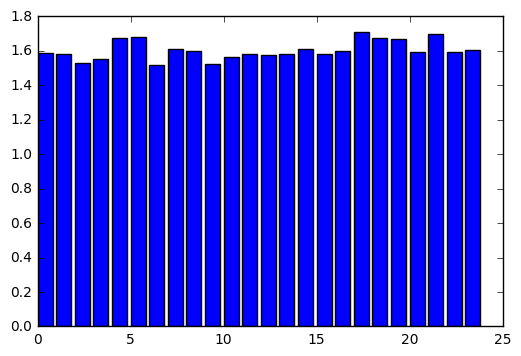

In [18]:
# QN POSTED TIME - VS - ANSWER COUNT
boxplotData = []
X = []
Y = []
sumCount = qnsData['AnsCount'].sum()
for i in range(24):
    df = qnsData[(qnsData['HourOfDay'] == i) & (qnsData['AnsCount'] < 100)]['AnsCount']
    df = df / sumCount
    boxplotData.append(df.values)
    val = qnsData[qnsData['HourOfDay'] == i]['AnsCount'].mean()
    # val = qnsData[qnsData['DayOfWeek'] == i]['AnsCount'].mean()
    X.append(i)
    Y.append(val)

# plt.boxplot(boxplotData,0,'')
# plt.scatter(qnsData['DayOfWeek'],qnsData['AnsCount'])
# df = qnsData[qnsData['AnsCount'] < 100]
# plt.scatter(df['DayOfWeek'],df['AnsCount'])
plt.bar(X,Y)
plt.show()

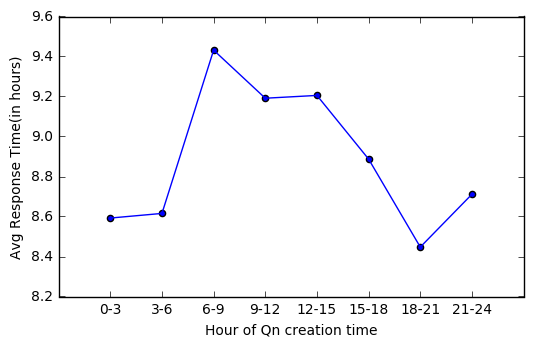

In [20]:
# QN POSTED TIME - VS - FIRST ANSWER RESPONSE TIME
df1 = qnsData[qnsData['HourOfDay'].between(0, 3, inclusive=True)]['FirstResponse'].mean()
df2 = qnsData[qnsData['HourOfDay'].between(3, 6, inclusive=True)]['FirstResponse'].mean()
df3 = qnsData[qnsData['HourOfDay'].between(6, 9, inclusive=True)]['FirstResponse'].mean()
df4 = qnsData[qnsData['HourOfDay'].between(9, 12, inclusive=True)]['FirstResponse'].mean()
df5 = qnsData[qnsData['HourOfDay'].between(12, 15, inclusive=True)]['FirstResponse'].mean()
df6 = qnsData[qnsData['HourOfDay'].between(15, 18, inclusive=True)]['FirstResponse'].mean()
df7 = qnsData[qnsData['HourOfDay'].between(18, 21, inclusive=True)]['FirstResponse'].mean()
df8 = qnsData[qnsData['HourOfDay'].between(21, 24, inclusive=True)]['FirstResponse'].mean()

fig = plt.figure()
# plt.boxplot([df1,df2,df3,df4,df5,df6,df7,df8],0,'')
X = list(range(1,9))
plt.scatter(X,[df1,df2,df3,df4,df5,df6,df7,df8])
plt.plot(X,[df1,df2,df3,df4,df5,df6,df7,df8])

labels = ['0-3', '3-6', '6-9', '9-12', '12-15', '15-18', '18-21', '21-24']
plt.xticks(X, labels)
plt.xlabel('Hour of Qn creation time')
plt.ylabel('Avg Response Time(in hours)')
plt.subplots_adjust(bottom=0.2)
plt.show()
fig.savefig('assignment2/QnHourVsFirstResponse.png')

In [21]:
# TAG POPULARITY - VS - ANSWER COUNT
def getTagPopularity(qnid):
    df = tagsFeaturesData[tagsFeaturesData['qnid'] == qnid]
    return df['avg_popularity'].values[0]

qnsData['AvgPopularity'] = qnsData['Id'].map(getTagPopularity)

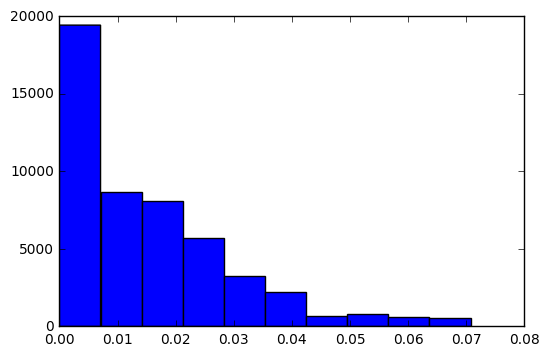

In [23]:
plt.hist(qnsData['AvgPopularity'])
plt.show()

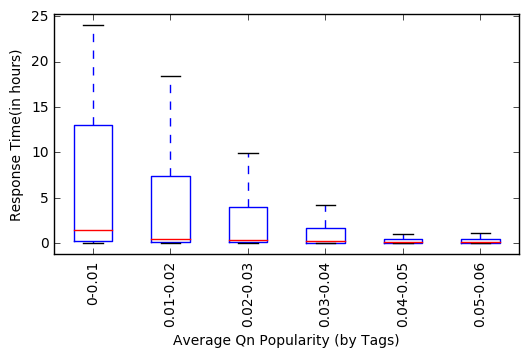

In [44]:
df1 = qnsData[qnsData['AvgPopularity'].between(0.00, 0.01, inclusive=True)]['FirstResponse']
df2 = qnsData[qnsData['AvgPopularity'].between(0.01, 0.02, inclusive=True)]['FirstResponse']
df3 = qnsData[qnsData['AvgPopularity'].between(0.02, 0.03, inclusive=True)]['FirstResponse']
df4 = qnsData[qnsData['AvgPopularity'].between(0.03, 0.04, inclusive=True)]['FirstResponse']
df5 = qnsData[qnsData['AvgPopularity'].between(0.04, 0.05, inclusive=True)]['FirstResponse']
df6 = qnsData[qnsData['AvgPopularity'].between(0.05, 0.06, inclusive=True)]['FirstResponse']


fig = plt.figure()
plt.boxplot([df1,df2,df3,df4,df5,df6],0,'')
labels = ['0-0.01', '0.01-0.02', '0.02-0.03', '0.03-0.04', '0.04-0.05', '0.05-0.06']
plt.xticks(list(range(1,7)), labels,rotation='vertical')
plt.xlabel('Average Qn Popularity (by Tags)')
plt.ylabel('Response Time(in hours)')
plt.subplots_adjust(bottom=0.3)
plt.margins(0.05)
plt.show()
fig.savefig('assignment2/TagPopVsFirstResponse.png')

In [ ]:
df1 = qnsData[qnsData['AvgPopularity'].between(0.00, 0.01, inclusive=True)]['AnsCount'].mean()
df2 = qnsData[qnsData['AvgPopularity'].between(0.01, 0.02, inclusive=True)]['AnsCount'].mean()
df3 = qnsData[qnsData['AvgPopularity'].between(0.02, 0.03, inclusive=True)]['AnsCount'].mean()
df4 = qnsData[qnsData['AvgPopularity'].between(0.03, 0.04, inclusive=True)]['AnsCount'].mean()
df5 = qnsData[qnsData['AvgPopularity'].between(0.04, 0.05, inclusive=True)]['AnsCount'].mean()
df6 = qnsData[qnsData['AvgPopularity'].between(0.05, 0.06, inclusive=True)]['AnsCount'].mean()
df7 = qnsData[qnsData['AvgPopularity'].between(0.06, 0.07, inclusive=True)]['AnsCount'].mean()
df8 = qnsData[qnsData['AvgPopularity'].between(0.07, 0.08, inclusive=True)]['AnsCount'].mean()

fig = plt.figure()
X = list(range(1,9))
Y = [df1,df2,df3,df4,df5,df6,df7,df8]
plt.scatter(X,Y)
plt.plot(X,Y)
labels = ['0-0.01', '0.01-0.02', '0.02-0.03', '0.03-0.04', '0.04-0.05',
          '0.05-0.06','0.06-0.07','0.07-0.08']
plt.xticks(X, labels,rotation='vertical')
plt.xlabel('Average Qn Popularity (by Tags)')
plt.ylabel('Avg # of Answers received')
plt.subplots_adjust(bottom=0.3)
plt.margins(0.05)
plt.show()
fig.savefig('assignment2/TagPopVsAnsCount.png')

In [27]:
# Takes 5 mins
def getReputation(userid):
    user = usersData[usersData['User Id']==userid]
    if len(user) == 0:
        return 0
    return user['Reputation'].values[0]

users_response_df['Reputation'] = users_response_df['userid'].apply(getReputation)

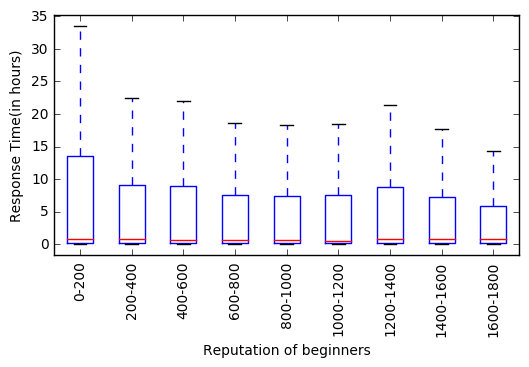

In [36]:
df = users_response_df[users_response_df['Reputation'] != 0]

df1 = df[df['Reputation'].between(0, 200, inclusive=True)]['mean_response_time']
df2 = df[df['Reputation'].between(200, 400, inclusive=True)]['mean_response_time']
df3 = df[df['Reputation'].between(400, 600, inclusive=True)]['mean_response_time']
df4 = df[df['Reputation'].between(600, 800, inclusive=True)]['mean_response_time']
df5 = df[df['Reputation'].between(800, 1000, inclusive=True)]['mean_response_time']
df6 = df[df['Reputation'].between(1000, 1200, inclusive=True)]['mean_response_time']
df7 = df[df['Reputation'].between(1200, 1400, inclusive=True)]['mean_response_time']
df8 = df[df['Reputation'].between(1400, 1600, inclusive=True)]['mean_response_time']
df9 = df[df['Reputation'].between(1600, 1800, inclusive=True)]['mean_response_time']
df10 = df[df['Reputation'].between(1800, 2000, inclusive=True)]['mean_response_time']


plt.show()

fig = plt.figure()
X = list(range(1,10))
Y = [df1,df2,df3,df4,df5,df6,df7,df8,df10]
plt.boxplot(Y,0,'')
labels = ['0-200', '200-400', '400-600', '600-800', '800-1000',
          '1000-1200','1200-1400','1400-1600','1600-1800']
plt.xticks(X, labels,rotation='vertical')
plt.xlabel('Reputation of beginners')
plt.ylabel('Response Time(in hours)')
plt.subplots_adjust(bottom=0.3)
plt.margins(0.05)
plt.show()
fig.savefig('assignment2/ReputationVsResponseTime.png')

In [37]:
qnFeatureFilepath = basepath + '/input/X_ling_feat.txt'
qnFeatureData = pd.read_table(qnFeatureFilepath,sep=' ')
qnFeatureData = qnFeatureData[:50000]

In [38]:
qnsData['error_ratio_title'] = qnFeatureData['error_ratio_title'].values
qnsData['error_ratio_body'] = qnFeatureData['error_ratio_body'].values
qnsData['isimage'] = qnFeatureData['isimage'].values
qnsData['iscode'] = qnFeatureData['iscode'].values
qnsData['islink'] = qnFeatureData['islink'].values

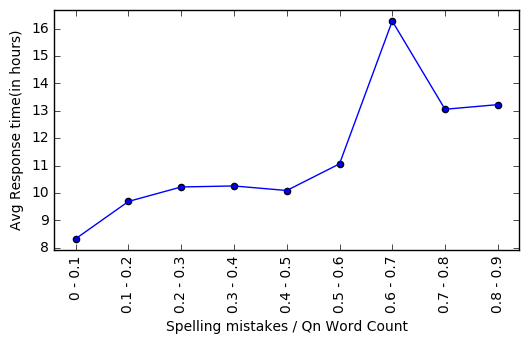

In [39]:
df = qnsData
df1 = df[df['error_ratio_body'].between(0, 0.1, inclusive=True)]['FirstResponse'].mean()
df2 = df[df['error_ratio_body'].between(0.1, 0.2, inclusive=True)]['FirstResponse'].mean()
df3 = df[df['error_ratio_body'].between(0.2, 0.3, inclusive=True)]['FirstResponse'].mean()
df4 = df[df['error_ratio_body'].between(0.3, 0.4, inclusive=True)]['FirstResponse'].mean()
df5 = df[df['error_ratio_body'].between(0.4, 0.5, inclusive=True)]['FirstResponse'].mean()
df6 = df[df['error_ratio_body'].between(0.5, 0.6, inclusive=True)]['FirstResponse'].mean()
df7 = df[df['error_ratio_body'].between(0.6, 0.7, inclusive=True)]['FirstResponse'].mean()
df8 = df[df['error_ratio_body'].between(0.7, 0.8, inclusive=True)]['FirstResponse'].mean()
df9 = df[df['error_ratio_body'].between(0.8, 0.9, inclusive=True)]['FirstResponse'].mean()

fig = plt.figure()
X = list(range(1,10))
Y = [df1,df2,df3,df4,df5,df6,df7,df8,df9]
plt.scatter(X,Y)
plt.plot(X,Y)
labels = ['0 - 0.1', '0.1 - 0.2', '0.2 - 0.3','0.3 - 0.4','0.4 - 0.5','0.5 - 0.6',
          '0.6 - 0.7','0.7 - 0.8','0.8 - 0.9']
plt.xticks(X, labels,rotation='vertical')
plt.xlabel('Spelling mistakes / Qn Word Count')
plt.ylabel('Avg Response time(in hours)')
plt.subplots_adjust(bottom=0.3)
plt.margins(0.05)
plt.show()
fig.savefig('assignment2/SpellingmistakeVsResponseTime.png')

8.79209769712
11.0632061728
8.38074993216
11.1482001832
9.91066676858
8.54794877699


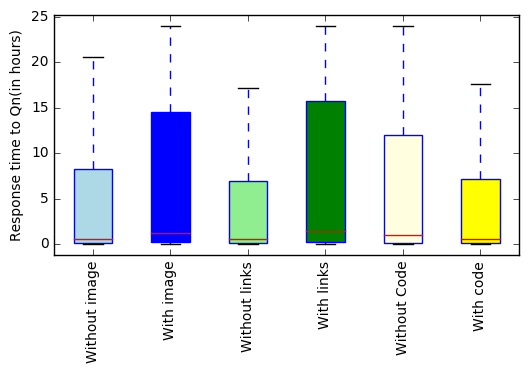

In [42]:
meanRT_noimage = qnsData[qnsData['isimage'] == 0]['FirstResponse']
meanRT_image = qnsData[qnsData['isimage'] == 1]['FirstResponse']

meanRT_nolink = qnsData[qnsData['islink'] == 0]['FirstResponse']
meanRT_link = qnsData[qnsData['islink'] == 1]['FirstResponse']

meanRT_nocode = qnsData[qnsData['iscode'] == 0]['FirstResponse']
meanRT_code = qnsData[qnsData['iscode'] == 1]['FirstResponse']

print(meanRT_noimage.mean())
print(meanRT_image.mean())
print(meanRT_nolink.mean())
print(meanRT_link.mean())
print(meanRT_nocode.mean())
print(meanRT_code.mean())

fig = plt.figure()
X = [1,2,3,4,5,6]
Y = [meanRT_noimage,meanRT_image,meanRT_nolink,meanRT_link,meanRT_nocode,meanRT_code]
# Y = [meanRT_noimage.mean(),meanRT_image.mean(),meanRT_nolink.mean(),meanRT_link.mean()
#         ,meanRT_nocode.mean(),meanRT_code.mean()]

box = plt.boxplot(Y,0,'',patch_artist=True)

colors = ['lightblue','blue', 'lightgreen', 'green', 'lightyellow','yellow']
for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)
labels = ['Without image', 'With image', 'Without links','With links','Without Code','With code']
plt.xticks(X, labels,rotation='vertical')
plt.ylabel('Response time to Qn(in hours)')
plt.subplots_adjust(bottom=0.3)
plt.margins(0.05)

plt.show()
fig.savefig('assignment2/QnFeaturesVsAvgResponseTime.png')

In [291]:
qnFeatureData[:3]

,isimage,islink,iscode,code_length,body_length,error_ratio_body,title_length,error_ratio_title
0,0.0,0.0,1.0,12.0,132.0,0.075758,7.0,0.142857
1,0.0,0.0,1.0,34.0,17.0,0.058824,6.0,0.166667
2,0.0,1.0,1.0,12.0,112.0,0.160714,9.0,0.222222


In [99]:
users_response_df[:3]

,mean_response_time,userid,Accept Rate,Reputation
0,0.065833,5.0,88.0,35735
1,0.555000,29.0,84.0,62609
2,0.203611,49.0,86.0,15318


In [30]:
usersData[:3]

,Unnamed: 0,Bronze Badges,Silver Badges,Gold Badges,Account Id,Is Employee,Reputation,User Id,Accept Rate
0,0,151,85,16,207149,False,23736,456851,99.0
1,1,216,130,47,103699,False,10796,277603,76.0
2,2,45,22,4,150205,False,4228,363224,80.0


In [61]:
tagsFeaturesData[:3]

,Unnamed: 0,qnid,tags,encoded_tags,avg_popularity,max_popularity
0,0,2120,"['sql', 'sql-server']","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, ...",0.01541,0.020633
1,1,2540,"['c', 'architecture', 'data-structures']","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.00444,0.013319
2,2,2630,"['powershell', 'cmdlets']","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.00000,0.000000


In [27]:
ansData[ansData.columns.difference(['Body','Unnamed: 0'])][:3]

,CreationDate,DayOfWeek,HourOfDay,Id,OwnerUserId,ParentId,PeriodOfDay,Score
0,2008-08-05T14:26:41Z,1,14,2382,383.0,2120,3,118
1,2008-08-05T16:43:11Z,1,16,2558,414.0,2540,4,11
2,2008-08-05T18:50:09Z,1,18,2697,199.0,2540,4,33


In [290]:
qnsData[qnsData.columns.difference(['DayOfWeek','Title','ClosedDate','CreationDate','Body','Unnamed: 0','OwnerUserId'])][:3]

,AnsCount,AvgPopularity,FirstResponse,HourOfDay,Id,Score,error_ratio_body,error_ratio_title,iscode,isimage,islink
0,2,0.007652,0.201389,6,8767810,1,0.075758,0.142857,1.0,0.0,0.0
1,3,0.019125,0.033056,0,9072820,0,0.058824,0.166667,1.0,0.0,0.0
2,1,0.003814,16.411111,21,34799780,0,0.160714,0.222222,1.0,0.0,1.0


In [132]:
tagsData[:10]

,Unnamed: 0,Id,Tag
0,72,2120,sql
1,73,2120,sql-server
2,81,2540,c
3,82,2540,architecture
4,83,2540,data-structures
5,88,2630,powershell
6,89,2630,cmdlets
7,90,2750,optimization
8,91,2750,setter
9,92,2750,getter


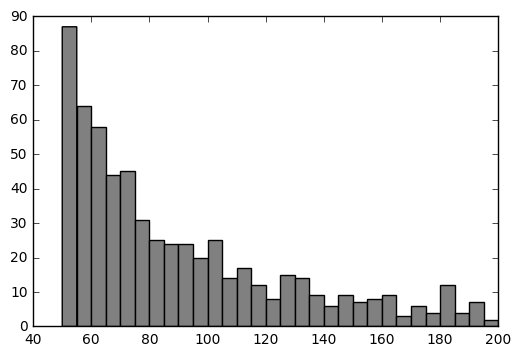

In [56]:
qnScores = qnsData['Score']
# plt.hist(qnScores)
plt.hist(qnScores, 30, range=[50, 200], facecolor='gray', align='mid')
# plt.scatter(qnsData['Score'].index,qnsData['Score'].values)
plt.show()